In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import auc, roc_curve
import warnings

import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from scipy.spatial.distance import cosine
from scipy.interpolate import make_interp_spline

A partir de la base de datos proporcionada, se realizará un programa que permita identificar las huellas del mismo usuario y descartar el resto, dando información cuantitativa de la similitud entre las huellas, pudiendo utilizar openCV, numpy, os, PyTorch,..., pero no funciones descargadas especialmente para trabajar con huellas dactilares.

Se obtendrá la función densidad de probabilidad, la curva DET, la curva ROC., el valor EER y el valor AUC.

Se realizará un póster (una única transparencia) y se presentará durante la última semana de clase. Además, se entregará el código usado.

En la presentación tienen que tratarse los siguientes puntos:

-Hipótesis de partida.

-Metodología utilizada y explicación de su desarrollo.

-Resultados (curvas, EER y AUC).

-Conclusiones.

-Fuentes principales consultadas.

## 1. Limpieza del dataset

### 1.2. Extraer la huella de la imagen

In [3]:
from clean_dataset.hand_cleaning import build_dataset
from clean_dataset.scikit_cleaning  import build_dataset_frangi

In [4]:
sample_path = r"\BaseDatosNISTsd09_pr"
output_hand_dataset = "./datasets/hand_dataset"
output_frangi_dataset = "./datasets/frangi_dataset"
sample_path = os.getcwd()+sample_path
subfolders= os.listdir(sample_path)

build_dataset_frangi(sample_path, subfolders, output_frangi_dataset)
build_dataset(sample_path, subfolders, output_hand_dataset)

## 2. Planteamiento del sistema

In [5]:
sample_path = r"\BaseDatosNISTsd09_pr"
output_hand_dataset = "./datasets/hand_dataset"
output_frangi_dataset = "./datasets/frangi_dataset"
sample_path = os.getcwd()+sample_path
subfolders= os.listdir(sample_path)

In [6]:
targets = {}
i = 0

for folder in subfolders:
    for file in os.listdir(sample_path + "/" + folder):
        targets[file] = 1
    if i == 6:
        break
    i += 1

i = 0
for folder in subfolders:
    if i > 6:
        for file in os.listdir(sample_path + "/" + folder):
            targets[file] = 0
    i += 1

print(targets)

{'crd_0811f_01.png': 1, 'crd_0811s_01.png': 1, 'crd_0812f_01.png': 1, 'crd_0812s_01.png': 1, 'crd_0813f_01.png': 1, 'crd_0813s_01.png': 1, 'crd_0814f_01.png': 1, 'crd_0814s_01.png': 1, 'crd_0815f_01.png': 1, 'crd_0815s_01.png': 1, 'crd_0816f_01.png': 1, 'crd_0816s_01.png': 1, 'crd_0817f_01.png': 1, 'crd_0817s_01.png': 1, 'crd_0818f_01.png': 0, 'crd_0818s_01.png': 0, 'crd_0819f_01.png': 0, 'crd_0819s_01.png': 0, 'crd_0820f_01.png': 0, 'crd_0820s_01.png': 0}


### 2.1. SIFT (Scale-Invariant Feature Transform)

In [7]:
dataset_path = output_frangi_dataset
users = {}
i = 0

for subfolder in subfolders:
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]

    img = cv.imread(route)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    users[path[0]] = (kp, des, path[0])
    if i == 6:
        break
    i += 1


In [8]:
for subfolder in subfolders:
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]
    os.remove(route)

In [9]:
def find_match(new_kp, new_des, users, threshold=230):
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    for user_id, (kp, des, img) in users.items(): 
        matches = bf.match(new_des, des)
        sorted_matches = sorted(matches, key=lambda x: x.distance)

        if sorted_matches and sorted_matches[0].distance < threshold:
            return True, img

    return False, None 

#### 1. Curva DET (*Detection Error Tradeoff*)

La curva DET es un gráfico que muestra la relación entre las tasas de error de un sistema, en particular:
- **FAR (*False Acceptance Rate*)**: Tasa de falsas aceptaciones (también conocido como tasa de falsos positivos).
- **FRR (*False Rejection Rate*)**: Tasa de rechazos falsos (también conocido como tasa de falsos negativos).


In [ ]:
thresholds = np.linspace(0, 500, 300)
false_accepted = []
false_rejected = []
int_usuario_no = 6
int_usuarios_si = 7

dataset_path

for threshold in thresholds:
    number_false_rejected = 0
    number_false_accepted = 0
    for subfolder in subfolders:
        for file in os.listdir(dataset_path + '\\' + subfolder):
            path = dataset_path + '\\' + subfolder + '\\' + file
            true_target = targets[file]
            img = cv.imread(path)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            sift = cv.SIFT_create()
            kp, des = sift.detectAndCompute(gray, None)
            sift = cv.SIFT_create()
            new_kp, new_des = sift.detectAndCompute(gray, None)

            result, img_name = find_match(new_kp, new_des, users, threshold)
            if int(result) == 0 and true_target == 1:
                number_false_rejected += 1
            
            elif int(result) == 1 and true_target == 0:
                number_false_accepted += 1
    far = number_false_accepted / int_usuario_no
    frr = number_false_rejected / int_usuarios_si

    false_accepted.append(far)
    false_rejected.append(frr)

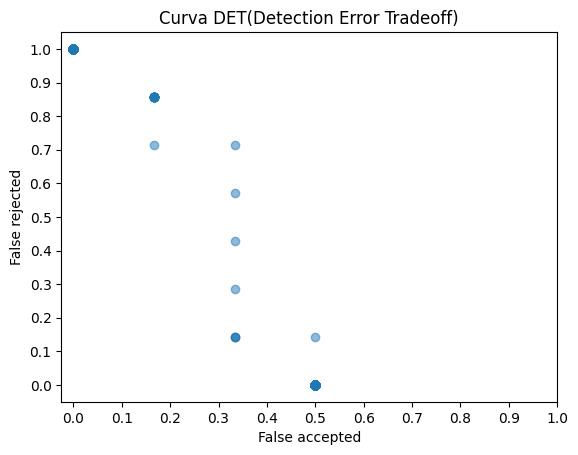

In [11]:
plt.plot(false_accepted, false_rejected, 'o', alpha=0.5)
plt.xlabel("False accepted")
plt.ylabel("False rejected")
plt.title("Curva DET(Detection Error Tradeoff)")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

##### 1.1. EER (*Equal Error Rate*)

El EER es el punto donde la FAR y la FRR son iguales. En otras palabras, es el punto de intersección entre ambas tasas cuando se grafican frente al umbral de decisión.

In [19]:
def identify_EER(far, frr):
    min_distance = float('inf')
    eer = 0
    eer_index = 0
    for i in range(len(far)):
        distance = abs(far[i] - frr[i])
        if distance < min_distance:
            min_distance = distance
            eer = (far[i] + frr[i]) / 2
            eer_index = i
    return eer, eer_index


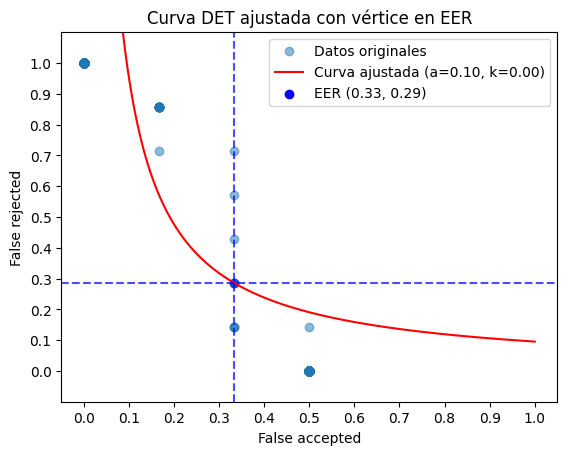

In [22]:
eer, eer_index = identify_EER(false_accepted, false_rejected)
x_vertex, y_vertex = false_accepted[eer_index], false_rejected[eer_index]

h = 0
a = (y_vertex - 0) * x_vertex
k = y_vertex - a / x_vertex

def rational_function(x):
    return a / (x - h) + k

x_smooth = np.linspace(0.07, 1, 500)
y_smooth = rational_function(x_smooth)

plt.plot(false_accepted, false_rejected, 'o', alpha=0.5, label="Datos originales")
plt.plot(x_smooth, y_smooth, '-', color='red', label=f"Curva ajustada (a={a:.2f}, k={k:.2f})")

plt.scatter([x_vertex], [y_vertex], color='blue', label=f"EER ({x_vertex:.2f}, {y_vertex:.2f})")
plt.axvline(x_vertex, color='blue', linestyle='--', alpha=0.7)
plt.axhline(y_vertex, color='blue', linestyle='--', alpha=0.7)

plt.xlabel("False accepted")
plt.ylabel("False rejected")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(-0.1, 1.1)
plt.title("Curva DET ajustada con vértice en EER")
plt.legend()
plt.show()


Para el algoritmo SIFT, se obtuvo un EER del 0.30 aproximadamente.

#### 2. Densidad de probabilidad

La función de densidad de probabilidad (PDF) describe cómo se distribuyen las probabilidades de las variables aleatorias en un dominio continuo. La PDF proporciona una forma de representar y analizar la probabilidad de que una variable tome ciertos valores dentro de un rango específico.

In [ ]:
from scipy.stats import gaussian_kde

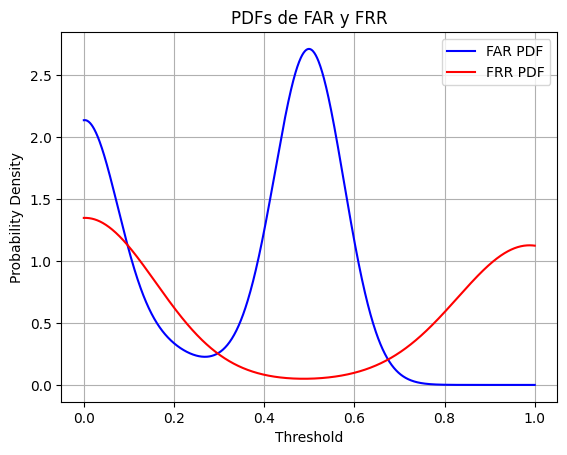

In [25]:
false_accepted = np.array(false_accepted)
false_rejected = np.array(false_rejected)

kde_far = gaussian_kde(false_accepted)
kde_frr = gaussian_kde(false_rejected)

x_range = np.linspace(0, 1, 1000)

pdf_far = kde_far(x_range)
pdf_frr = kde_frr(x_range)

plt.plot(x_range, pdf_far, label="FAR PDF", color='blue')
plt.plot(x_range, pdf_frr, label="FRR PDF", color='red')

plt.xlabel("Threshold")
plt.ylabel("Probability Density")
plt.title("PDFs de FAR y FRR")
plt.legend()
plt.grid(True)
plt.show()


En general, el sistema muestra un compromiso entre falsas aceptaciones (FAR) y falsos rechazos (FRR). Los picos de probabilidad sugieren que el sistema tiene un umbral donde se favorece ligeramente la aceptación de usuarios no válidos sobre el rechazo de usuarios legítimos. 

El análisis indica que el sistema tiene una buena estructura de detección, pero podría beneficiarse de ajustes de umbral o parámetros para optimizar el rendimiento en función de los objetivos finales (por ejemplo, mayor seguridad o mayor accesibilidad).

#### 3. Curva ROC y AUC

La curva ROC (*Receiver Operating Characteristic*) es una representación gráfica que evalúa el rendimiento de un clasificador binario en función de diferentes umbrales de decisión. 
El AUC (*Area Under the Curve*) es una métrica derivada de la curva ROC que mide el área bajo la curva ROC.

In [26]:
true_positive_rates = []
false_positive_rates = []
thresholds = np.linspace(0, 500, 300)

for threshold in thresholds:
    number_false_rejected = 0
    number_false_accepted = 0
    true_positive = 0
    true_negative = 0
    total_positive = 0
    total_negative = 0

    for subfolder in subfolders:
        for file in os.listdir(dataset_path + '\\' + subfolder):
            path = dataset_path + '\\' + subfolder + '\\' + file
            true_target = targets[file]
            img = cv.imread(path)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            sift = cv.SIFT_create()
            new_kp, new_des = sift.detectAndCompute(gray, None)

            result, img_name = find_match(new_kp, new_des, users, threshold)

            if true_target == 1:
                total_positive += 1
                if int(result) == 1:
                    true_positive += 1
                else:
                    number_false_rejected += 1
            else:
                total_negative += 1
                if int(result) == 0:
                    true_negative += 1
                else:
                    number_false_accepted += 1

    tpr = true_positive / total_positive if total_positive else 0
    fpr = number_false_accepted / total_negative if total_negative else 0

    true_positive_rates.append(tpr)
    false_positive_rates.append(fpr)

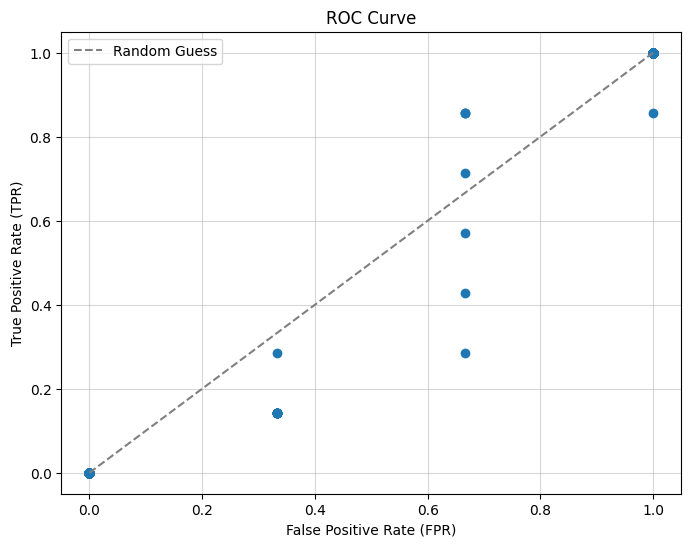

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rates, true_positive_rates, marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

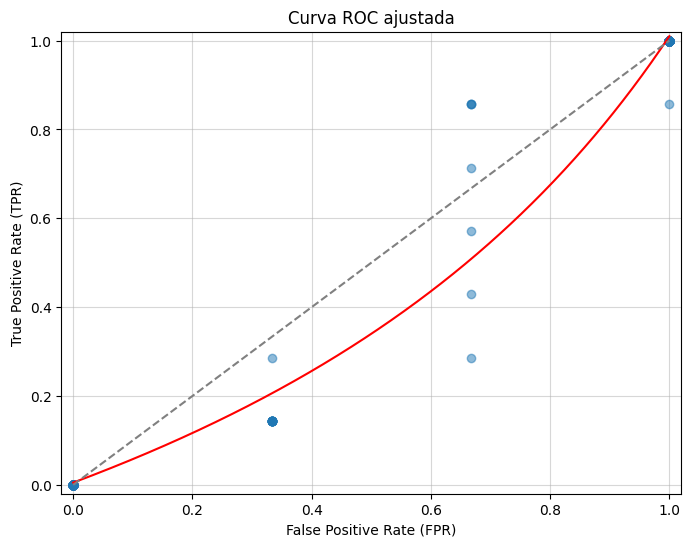

In [97]:
x_vertex, y_vertex = 0.5, 0.34
h = 2
k = -1  
a = (y_vertex - k) * (x_vertex - h)


x_smooth = np.linspace(0, 1, 500)
y_smooth = rational_function(x_smooth)

plt.figure(figsize=(8, 6))
plt.plot(false_positive_rates, true_positive_rates, 'o', alpha=0.5, label="Datos originales")
plt.plot(x_smooth, y_smooth, '-', color='red', label=f"Curva ajustada (a={a:.2f}, k={k:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.axvline(h, color='orange', linestyle='--', label="Asíntota vertical (x=0)")
plt.axhline(k, color='green', linestyle='--', label="Asíntota horizontal (y=0.6)")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC ajustada")
plt.ylim(-0.02, 1.02)
plt.xlim(-0.02, 1.02)
plt.grid(alpha=0.5)

plt.show()

In [98]:
roc_auc = auc(false_positive_rates, true_positive_rates)
print(f"Área bajo la curva (AUC): {roc_auc}")

Área bajo la curva (AUC): 0.40476190476190477


#### 4. Accuracy

In [101]:
thresholds = np.linspace(0, 500, 300)
accuracies = []

int_usuario_no = 6
int_usuarios_si = 7

for threshold in thresholds:
    correct_predictions = 0
    total_predictions = 0

    for subfolder in subfolders:
        for file in os.listdir(dataset_path + '\\' + subfolder):
            path = dataset_path + '\\' + subfolder + '\\' + file
            true_target = targets[file]
            
            img = cv.imread(path)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            sift = cv.SIFT_create()
            new_kp, new_des = sift.detectAndCompute(gray, None)
            result, img_name = find_match(new_kp, new_des, users, threshold)

            if int(result) == true_target:
                correct_predictions += 1

            total_predictions += 1

    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)

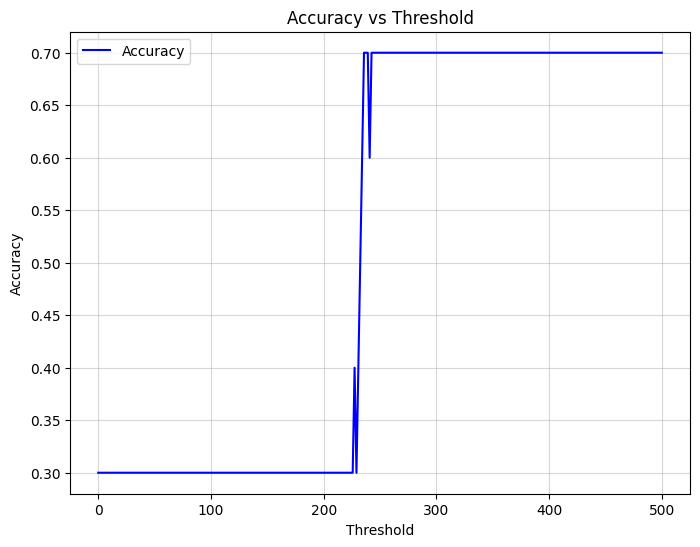

In [102]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies, label='Accuracy', color='blue')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [103]:
best_accuracy_index = np.argmax(accuracies)  # Índice del mejor accuracy
best_threshold = thresholds[best_accuracy_index]
print(f"Mejor accuracy: {accuracies[best_accuracy_index]:.2f} con threshold = {best_threshold:.2f}")

Mejor accuracy: 0.70 con threshold = 235.79


In [ ]:
print("\nEtiquetas clasificadas usando el mejor threshold:")

for subfolder in subfolders:
    for file in os.listdir(dataset_path + '\\' + subfolder):
        path = dataset_path + '\\' + subfolder + '\\' + file
        true_target = targets[file]
        
        img = cv.imread(path)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        sift = cv.SIFT_create()
        new_kp, new_des = sift.detectAndCompute(gray, None)
        result, img_name = find_match(new_kp, new_des, users, best_threshold)
        predicted_label = "Valid" if int(result) == 1 else "Invalid"
        true_label = "Valid" if true_target == 1 else "Invalid"
        print(f"Archivo: {file} | Predicción: {predicted_label} | Verdadero: {true_label}")


Etiquetas clasificadas usando el mejor threshold:
Archivo: crd_0811s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0812s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0813s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0814s_01.png | Predicción: Invalid | Verdadero: Valid
Archivo: crd_0815s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0816s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0817s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0818s_01.png | Predicción: Valid | Verdadero: Invalid
Archivo: crd_0819s_01.png | Predicción: Valid | Verdadero: Invalid
Archivo: crd_0820s_01.png | Predicción: Invalid | Verdadero: Invalid


### 2.2. ResNet pre-entrenada

In [51]:
def extract_features(img_path, model):
    model.eval()
    image = cv.imread(img_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image).unsqueeze(0)

    with torch.no_grad():
        features = model(image).squeeze().numpy()
    return features

def compare_fingerprints(users, v2, threshold=0.1):
    for idx, user in enumerate(users):
        user = user.flatten() if user.ndim > 1 else user
        v2 = v2.flatten() if v2.ndim > 1 else v2
        
        distance = cosine(user, v2)
        if distance < threshold:
            return True
    return False

In [52]:
warnings.filterwarnings("ignore")
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])

In [49]:
users = []
sample_path = r"\BaseDatosNISTsd09_pr"
dataset_path = "./datasets/hand_dataset"
sample_path = os.getcwd() + sample_path
subfolders = os.listdir(sample_path)

for i, subfolder in enumerate(subfolders[:6]):
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]
    vector = extract_features(route, model)
    users.append(vector)

In [53]:
correct = 0
true_positive = 0
true_negative = 0
total = 0

thresholds = np.linspace(0, 1, 100)
false_accepted = []
false_rejected = []
int_usuario_no = 6
int_usuarios_si = 7

distances = []
labels = []

for threshold in thresholds:
    number_false_rejected = 0
    number_false_accepted = 0

    for subfolder in subfolders:
        path = os.listdir(dataset_path + '\\' + subfolder)
        
        for file_name in path:
            route = dataset_path + '\\' + subfolder + '\\' + file_name
            true_target = targets[file_name]
            v2 = extract_features(route, model)
            
            result = compare_fingerprints(users, v2, threshold)
            

            if int(result) == 0 and true_target == 1:
                number_false_rejected += 1
            
            elif int(result) == 1 and true_target == 0:
                number_false_accepted += 1
            
            elif int(result) == true_target:
                correct += 1
            total += 1
    far = number_false_accepted / int_usuario_no
    frr = number_false_rejected / int_usuarios_si

    false_accepted.append(far)
    false_rejected.append(frr)


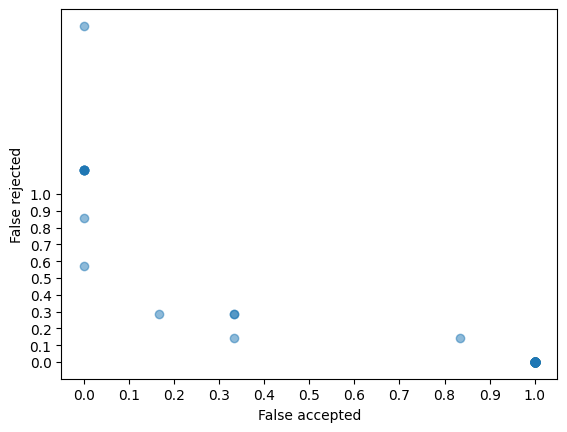

In [54]:
plt.plot(false_accepted, false_rejected, 'o', alpha=0.5)
plt.xlabel("False accepted")
plt.ylabel("False rejected")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

el error rate es 0.3

#### 2. Densidad de probabilidad

#### 3. Curva ROC y AUC

In [56]:
distances = []
labels = []

for subfolder in subfolders:
    path = os.listdir(dataset_path + '\\' + subfolder)
    
    for file_name in path:
        route = dataset_path + '\\' + subfolder + '\\' + file_name
        true_target = targets[file_name]
        v2 = extract_features(route, model)
        
        distance = cosine(users[0], v2)
        distances.append(distance)
        labels.append(true_target)

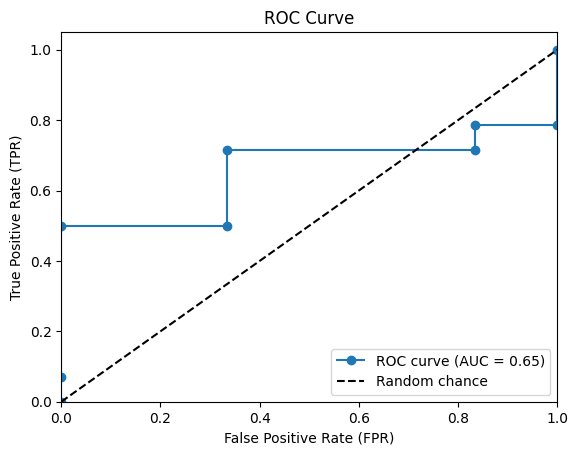

AUC: 0.6548


In [61]:
distances = np.array(distances)
labels = np.array(labels)

fpr, tpr, thresholds = roc_curve(labels, -distances)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', marker='o')
plt.plot([0, 1], [0, 1], 'k--', label="Random chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")

### 2.3 Red Convolutiva desde cero

#### Data Augmentation

In [9]:
import os
import cv2 as cv

def generate_rotated_img(img, angle, base_name, extension, root):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated_img = cv.warpAffine(img, M, (w, h))
    rotated_image_path = os.path.join(root, f"{base_name}_{angle}_grades{extension}")
    cv.imwrite(rotated_image_path, rotated_img)

def rotate_images_in_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                image_path = os.path.join(root, file)
                img = cv.imread(image_path)
                base_name = os.path.splitext(file)[0]
                extension = os.path.splitext(file)[1]
                for angle in range(1, 181):
                    generate_rotated_img(img, angle, base_name, extension, root)

#### Identificación y autentificación

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),  # Volteo horizontal
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_train = ImageFolder("./datasets/conv_ide_auten_train", transform=transform)
dataset = ImageFolder("./datasets/conv_ide_auten_test", transform=transform)

train_size = int(0.7 * len(dataset_train))
test_size = int(0.2 * len(dataset_train)) 
eval_size = int(0.1 * len(dataset_train))
train_dataset, _, eval_dataset = random_split(dataset_train, [train_size, test_size, eval_size])

_ = int(0.7 * len(dataset))
test_size = int(0.3 * len(dataset))
test_dataset, _ = random_split(dataset, [test_size, _])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Entrada: 1 canal, Salida: 16 canales, kernel de 5x5
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con un kernel de 2x2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Entrada: 16 canales, Salida: 32 canales
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Imágenes reducidas a 7x7 después del pooling
        self.fc2 = nn.Linear(120, 8)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Epoch 1/10, Loss: 1.6531487375497818
Epoch 2/10, Loss: 1.1373510301113128
Epoch 3/10, Loss: 0.7272274330258369
Epoch 4/10, Loss: 0.4989319249987602
Epoch 5/10, Loss: 0.33811568319797514
Epoch 6/10, Loss: 0.25054623670876025
Epoch 7/10, Loss: 0.19552780985832213
Epoch 8/10, Loss: 0.1600322648882866
Epoch 9/10, Loss: 0.14845523722469806
Epoch 10/10, Loss: 0.15088140992447735
Error Rate: 85.27%


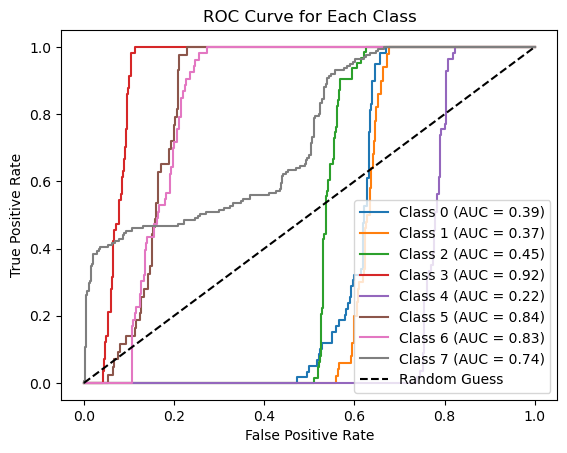

In [5]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

correct = 0
total = 0
true_positive = 0
true_negative = 0

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)  # Convertir las salidas a probabilidades
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convertir las listas a arrays
all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

# Error rate
predicted_classes = np.argmax(all_probs, axis=1)
error_rate = 1 - np.mean(predicted_classes == all_labels)
print(f"Error Rate: {error_rate:.2%}")

# Generar la curva ROC para cada clase
n_classes = all_probs.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convertir las etiquetas a formato binario one-vs-rest para calcular ROC por clase
for i in range(n_classes):
    binary_labels = (all_labels == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()


#### Siames

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import random

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(128*4*4, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128)
        )
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [11]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, indices, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.indices = indices
        self.transform = transform
        
    def __getitem__(self, index):
        img0_idx = random.choice(self.indices)
        img0_tuple = self.imageFolderDataset.imgs[img0_idx]
        
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                img1_idx = random.choice(self.indices)
                img1_tuple = self.imageFolderDataset.imgs[img1_idx]
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_idx = random.choice(self.indices)
                img1_tuple = self.imageFolderDataset.imgs[img1_idx]
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1, torch.from_numpy(np.array([int(img0_tuple[1] != img1_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.indices)


In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [14]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_train = datasets.ImageFolder("./datasets/conv_ide_auten_train", transform=transform)
dataset_test = datasets.ImageFolder("./datasets/conv_ide_auten_test", transform=transform)

train_size = int(0.7 * len(dataset_train))
test_size = int(0.2 * len(dataset_train))
eval_size = int(0.1 * len(dataset_train))

train_dataset, test_temp, eval_dataset = random_split(dataset_train, [train_size, test_size, eval_size])

test_size = int(0.3 * len(dataset_test))
test_dataset, _ = random_split(dataset_test, [test_size, len(dataset_test) - test_size])

siamese_train_dataset = SiameseNetworkDataset(imageFolderDataset=dataset_train, indices=train_dataset.indices, transform=transform)
siamese_test_dataset = SiameseNetworkDataset(imageFolderDataset=dataset_test, indices=test_dataset.indices, transform=transform)
siamese_eval_dataset = SiameseNetworkDataset(imageFolderDataset=dataset_train, indices=eval_dataset.indices, transform=transform)

train_loader = DataLoader(siamese_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(siamese_test_dataset, batch_size=32, shuffle=False)
eval_loader = DataLoader(siamese_eval_dataset, batch_size=32, shuffle=False)

In [19]:
model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for img0, img1, label in train_loader:
        img0, img1, label = img0, img1, label
        optimizer.zero_grad()
        output1, output2 = model(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/10, Loss: 0.2940828107297421
Epoch 2/10, Loss: 0.2761907819658518
Epoch 3/10, Loss: 0.2797624856233597
Epoch 4/10, Loss: 0.2711556661874056
Epoch 5/10, Loss: 0.2703714407980442
Epoch 6/10, Loss: 0.2710442665964365
Epoch 7/10, Loss: 0.2707985892891884
Epoch 8/10, Loss: 0.26986206099390986
Epoch 9/10, Loss: 0.2651054676622152
Epoch 10/10, Loss: 0.26736475676298144


In [28]:
# Verificar si se dispone de una GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover el modelo al dispositivo
model.to(device)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for img0, img1, label in test_loader:

        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        output1, output2 = model(img0, img1)

        euclidean_distance = F.pairwise_distance(output1, output2)

        predicted = (euclidean_distance > 0.5).float()
        
        predicted = predicted.view(-1) 
        label = label.view(-1).float()

        total += label.size(0)

        correct += (predicted == label).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 54.51%
